In [1]:
import os
from PIL import Image

from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn

import pytorch3d
from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.renderer import ImplicitRenderer
from pytorch3d.renderer import NDCGridRaysampler
from pytorch3d.renderer import ray_bundle_to_ray_points
from pytorch3d.renderer import RayBundle
from pytorch3d.renderer import EmissionAbsorptionRaymarcher


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
batch_size = 1
screen_size = (320, 640)
# volume_size = (128, 128, 128)

# Rotation matrix and translation vector
R = torch.tensor([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]]).unsqueeze(0)
T = torch.tensor( [0, 0, 0] ).unsqueeze(0)

cameras = FoVPerspectiveCameras(
    R=R, 
    T=T, 
    device=device,
)

ray_sampler = NDCGridRaysampler(
    image_width = screen_size[1],
    image_height = screen_size[0],
    n_pts_per_ray = 512,
    min_depth = 0.001,
    max_depth = 4.0,
)

def blank_volumetric_function(
    ray_bundle: RayBundle,
    background_color: Tuple[float, float, float],
    **kwargs,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # first convert the ray origins, directions and lengths
    # to 3D ray point locations in world coords
    # ray_world_coords.shape = [batch_size, height, width, sampling_rate, xyz]
    ray_points_world = ray_bundle_to_ray_points(ray_bundle)

    # set the densities
    # ray_densities.shape = [batch_size, height, width, sampling_rate, 1]
    ray_densities = torch.ones_like(ray_points_world[..., [0]])
    
    # set the ray features to RGB colors 
    # ray_features.shape = [batch_size, height, width, sampling_rate, rgb]
    ray_features = torch.zeros_like(ray_points_world)

    # Process the background
    # ray_features[..., :] = torch.ones_like(ray_features[..., :])        # White
    # ray_features[..., :] = torch.rand_like(ray_features[..., :])        # Random
    # ray_features[..., :] = torch.zeros_like(ray_features[..., :])       # Black
    ray_features[..., [0]] = background_color[0] / 255 * torch.ones_like(ray_features[..., [0]])        
    ray_features[..., [1]] = background_color[1] / 255 * torch.ones_like(ray_features[..., [1]])         
    ray_features[..., [2]] = background_color[2] / 255 * torch.ones_like(ray_features[..., [2]])         
    return ray_densities, ray_features

ray_bundles = ray_sampler(cameras=cameras, volumetric_function=blank_volumetric_function)
rays_densities, rays_features = blank_volumetric_function(
    ray_bundle=ray_bundles, 
    background_color=(30, 50, 84),
)

ray_marcher = EmissionAbsorptionRaymarcher()
images = ray_marcher(
    rays_densities=rays_densities,
    rays_features=rays_features,
    ray_bundle=ray_bundles,
)


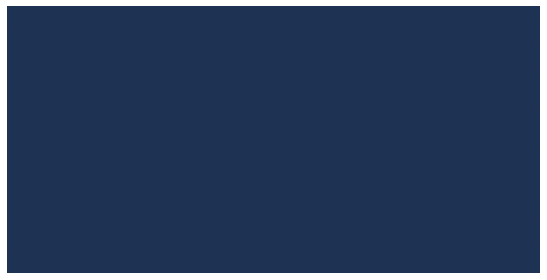

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True, frameon=False)
plt.imshow( images.cpu().numpy()[0, :, :] )
plt.axis("off")
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
